In [ ]:
import pandas as pd
import glob, re, os
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import f_oneway

**★Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**★データの準備**

In [2]:
# Import necessary libraries
# 必要なライブラリをインポート
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load player stats CSV
# 選手スタッツのCSVを読み込み
df = pd.read_csv('/content/drive/MyDrive/MIT_Sloan/wc2022_player_stats_newKPI3.csv')

# Define mapping from position name to large class
# ポジション名から大分類（Large Class）への対応辞書を定義
position_to_class = {
    "Goalkeeper": "GK",
    "Right Back": "FB",
    "Right Center Back": "CB",
    "Center Back": "CB",
    "Left Center Back": "CB",
    "Left Back": "FB",
    "Right Wing Back": "WB",
    "Left Wing Back": "WB",
    "Right Defensive Midfield": "CMF",
    "Center Defensive Midfield": "CMF",
    "Left Defensive Midfield": "CMF",
    "Right Midfield": "WG",
    "Right Center Midfield": "CMF",
    "Center Midfield": "CMF",
    "Left Center Midfield": "CMF",
    "Left Midfield": "WG",
    "Right Wing": "WG",
    "Right Attacking Midfield": "SS",
    "Center Attacking Midfield": "SS",
    "Left Attacking Midfield": "SS",
    "Left Wing": "WG",
    "Right Center Forward": "ST",
    "Striker": "ST",
    "Left Center Forward": "ST",
    "Secondary Striker": "SS",
    "Center Forward": "ST"
}

# Add new column 'Large_Class' based on position_name
# position_nameに基づいて新しい列 'Large_Class' を追加
df['Large_Class'] = df['position_name'].map(position_to_class)

# Display mapping result
# 対応結果を表示
print(df[['position_name', 'Large_Class']].head())

# Define mapping from position name to small class
# ポジション名から小分類（Small Class）への対応辞書を定義
position_name_to_small_class = {
    "Center Attacking Midfield": "CMF",
    "Center Back": "LCB",
    "Center Defensive Midfield": "CMF",
    "Center Midfield": "CMF",
    "Goalkeeper": "GK",
    "Left Attacking Midfield": "CMF",
    "Left Back": "LFB",
    "Left Center Back": "LCB",
    "Left Center Forward": "ST",
    "Left Center Midfield": "CMF",
    "Left Defensive Midfield": "CMF",
    "Left Midfield": "LWG",
    "Left Wing": "LWG",
    "Left Wing Back": "LWB",
    "Right Attacking Midfield": "CMF",
    "Right Back": "RFB",
    "Right Center Back": "RCB",
    "Right Center Forward": "ST",
    "Right Center Midfield": "CMF",
    "Right Defensive Midfield": "CMF",
    "Right Midfield": "RWG",
    "Right Wing": "RWG",
    "Right Wing Back": "RWB",
    "Secondary Striker": "ST",
    "Striker": "ST"
}

# Add new column 'small_class' based on position_name
# position_nameに基づいて新しい列 'small_class' を追加
df['small_class'] = df['position_name'].map(position_name_to_small_class)

# Remove rows with missing small_class
# small_classが欠損している行を除外
df = df[df['small_class'].notnull()]

# Convert duration from timedelta to minutes
# 出場時間（timedelta型）を分に変換
df['duration_minutes'] = pd.to_timedelta(df['duration']).dt.total_seconds() / 60

# Define list of stats to normalize per minute
# 1分あたりに正規化するスタッツ一覧を定義
stats_to_normalize = [
    'pass_CA', 'pass_HS', 'pass_SA',
    'carry_CA', 'carry_HS', 'carry_SA',
    'short_pass_side_attempt', 'short_pass_side_success',
    'short_pass_central_attempt', 'short_pass_central_success',
    'long_pass_attempts', 'long_pass_success',
    'vertical_pass_success', 'switch_pass_count',
    'cross_count', 'dribble_attempts', 'dribble_success',
    'pocket_entry', 'carry_into_PA', 'action_in_PA',
    'shot_count', 'xG_total'
]

# Remove rows where position_name is 'substitutions'
# 'substitutions' の行を除外（分析対象外）
df = df[df['position_name'] != 'substitutions']

# Normalize each stat per minute (fill NaN with 0)
# 各スタッツを1分あたりに換算（NaNは0で置換）
for stat in stats_to_normalize:
    df[f'{stat}_per_min'] = df[stat].fillna(0) / df['duration_minutes']

# Create list of normalized feature column names
# 正規化された特徴量列名一覧を作成
features = [f'{stat}_per_min' for stat in stats_to_normalize]

# Standardize features using sklearn
# sklearnを用いて特徴量を標準化
scaler = StandardScaler()
X_stats = scaler.fit_transform(df[features].fillna(0))

# Display normalized stats
# 正規化されたスタッツを表示
print(df[[f'{stat}_per_min' for stat in stats_to_normalize]].head())

# Save processed DataFrame to CSV
# 処理済みのDataFrameをCSVとして保存
df.to_csv('/content/drive/MyDrive/MIT_Sloan/position_stats_mean_per_min_small_class.csv', index=False)


       position_name Large_Class
0         Goalkeeper          GK
1  Right Center Back          CB
2        Center Back          CB
3   Left Center Back          CB
4    Right Wing Back          WB
   pass_CA_per_min  pass_HS_per_min  pass_SA_per_min  carry_CA_per_min  \
0         0.299103         0.119641         0.029910          0.898398   
1         0.039880         0.209372         0.329013          0.105702   
2         0.166564         0.314621         0.111043          0.239370   
3         0.069791         0.219342         0.558325          0.778774   
4         0.012876         0.038627         0.347639          0.000000   

   carry_HS_per_min  carry_SA_per_min  short_pass_side_attempt_per_min  \
0          0.613177          0.039992                         0.000000   
1          0.654806          1.460897                         0.239282   
2          2.462876          0.000000                         0.111043   
3          1.225922          1.236597                        

**Mean Values of Performance Stats by Position Class (ポジション分類ごとのパフォーマンススタッツ平均値)**

In [3]:
# Import necessary libraries
# 必要なライブラリをインポート
import pandas as pd
import numpy as np

# Column name representing player position
# 選手のポジションを表す列名
cluster_col = 'small_class'

# Calculate summary statistics: mean values for each stat grouped by position
# ポジションごとにスタッツの平均値を算出
summary_stats = df.groupby(cluster_col)[features].agg(['mean'])

# Flatten multi-level column names
# 多階層の列名をフラット化
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]

# Reset index to make 'small_class' a column
# インデックスをリセットして 'small_class' を列に戻す
summary_stats.reset_index(inplace=True)

# Create list of mean feature column names
# 平均値列に対応する新しい特徴量名リストを作成
mean_features = [f'{stat}_per_min_mean' for stat in stats_to_normalize]

# Create ranking DataFrame based on mean values
# 平均値に基づいてスタッツ順位を作成（値が高いほど上位）
position_ranking = summary_stats.copy()
for feature in mean_features:
    position_ranking[f'{feature}_rank'] = position_ranking[feature].rank(ascending=False)

# Recalculate summary statistics (mean only)
# 平均値のみを再度算出（簡易版）
summary_stats = df.groupby(cluster_col)[features].mean().reset_index()

# Count number of unique players per position
# ポジションごとのユニークな選手数（player_idの数）を算出
position_counts = df.groupby(cluster_col)['player_id'].nunique().reset_index()
position_counts.rename(columns={'player_id': 'player_count'}, inplace=True)

# Merge player counts into summary statistics
# 選手数を統計量に結合
summary_stats = summary_stats.merge(position_counts, on=cluster_col)

# Save summary statistics and rankings to CSV (optional)
# 統計量と順位をCSVとして保存（任意）
summary_stats.to_csv('/content/drive/MyDrive/position_stats_mean_per_min.csv', index=False)
position_ranking.to_csv('/content/drive/MyDrive/position_stats_ranking.csv', index=False)

**Tactical KPI Heatmap by Position Class with Group-wise Mean Value (ポジション別スタッツのヒートマップ＋群別平均値表示)**

/tmp/ipython-input-1677483794.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.268' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[stat] = annot_matrix.loc[stat].map(lambda x: f"{x:.3f}")
/tmp/ipython-input-1677483794.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.157' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[stat] = annot_matrix.loc[stat].map(lambda x: f"{x:.3f}")
/tmp/ipython-input-1677483794.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.150' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[stat] = annot_matrix.loc[stat].map(lambda x

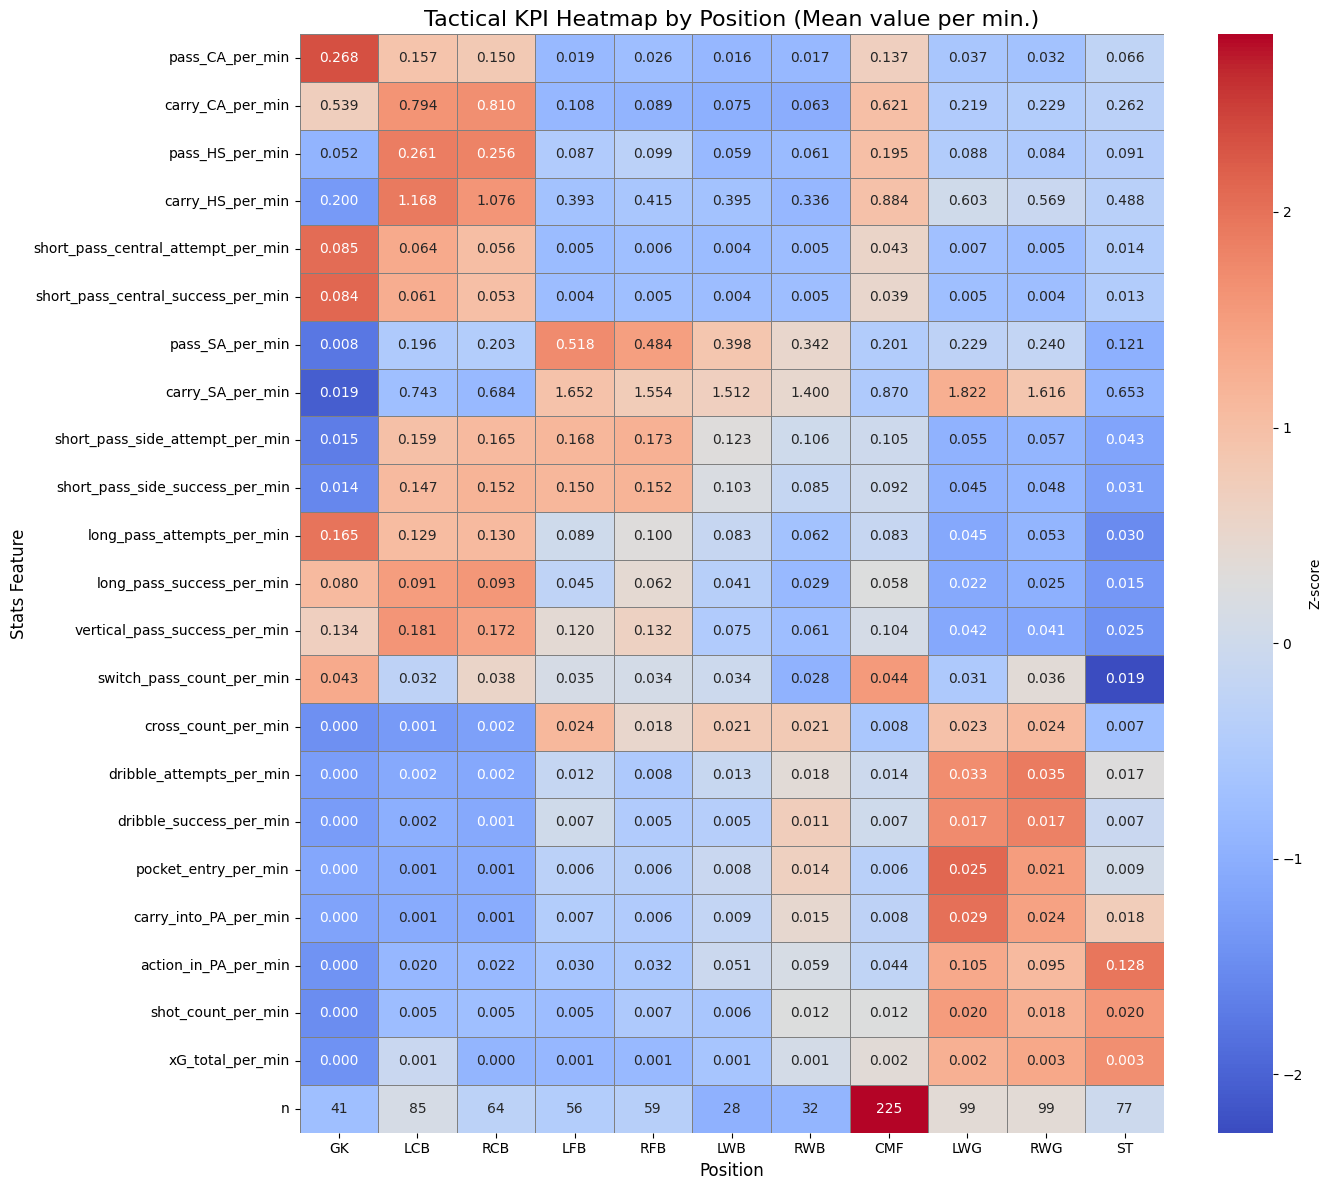

In [5]:
# Install required libraries (only needed once)
# 必要なライブラリのインストール（初回のみ）
# !pip install openpyxl seaborn matplotlib

# Import necessary libraries
# 必要なライブラリの読み込み
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Load summary stats CSV
# ポジション別スタッツ平均値のCSVを読み込み
df = pd.read_csv("/content/drive/MyDrive/position_stats_mean_per_min.csv")

# Convert player_count to integer and rename to 'n'
# player_count を整数に変換して 'n' に置き換え
df['n'] = df['player_count'].apply(lambda x: int(x))

# Define order of stats and positions for display
# 表示用のスタッツ順とポジション順を定義（player_count → n に変更）
stat_order = [
    'pass_CA_per_min', 'carry_CA_per_min', 'pass_HS_per_min', 'carry_HS_per_min',
    'short_pass_central_attempt_per_min', 'short_pass_central_success_per_min',
    'pass_SA_per_min', 'carry_SA_per_min',
    'short_pass_side_attempt_per_min', 'short_pass_side_success_per_min',
    'long_pass_attempts_per_min', 'long_pass_success_per_min',
    'vertical_pass_success_per_min', 'switch_pass_count_per_min',
    'cross_count_per_min', 'dribble_attempts_per_min', 'dribble_success_per_min',
    'pocket_entry_per_min', 'carry_into_PA_per_min', 'action_in_PA_per_min',
    'shot_count_per_min', 'xG_total_per_min', 'n'
]

# Define custom position order for display
# 表示用にポジション順を手動で指定
position_order = [
    'GK', 'LCB', 'RCB', 'LFB', 'RFB', 'LWB', 'RWB',
    'CMF', 'LWG', 'RWG', 'ST'
]

# Create raw matrix: stats × position
# 群別平均値行列の作成（スタッツ × ポジション）
raw_matrix = df.set_index('small_class')[stat_order].T
raw_matrix = raw_matrix[position_order]  # Reorder columns by position

# Create annotation matrix: format values for display
# アノテーション用の文字列行列を作成（n は整数、それ以外は小数第3位）
annot_matrix = raw_matrix.copy()
for stat in annot_matrix.index:
    if stat == 'n':
        annot_matrix.loc[stat] = annot_matrix.loc[stat].astype(int).astype(str)
    else:
        annot_matrix.loc[stat] = annot_matrix.loc[stat].map(lambda x: f"{x:.3f}")

# Convert annotation matrix to NumPy string array
# NumPy配列に変換（文字列型）
annot_array = annot_matrix.to_numpy().astype(str)

# Standardize stats using Z-score across rows
# 行方向にZスコアで標準化（スタッツごとの比較）
standardized_array = zscore(raw_matrix.astype(float), axis=1)
standardized_matrix = pd.DataFrame(standardized_array, index=raw_matrix.index, columns=raw_matrix.columns)

# Create heatmap with annotations
# アノテーション付きヒートマップの作成（群別平均値を表示）
plt.figure(figsize=(14, 12))
sns.heatmap(
    standardized_matrix,
    annot=annot_array,         # Display values as strings / 文字列として表示
    fmt="",                    # No formatting needed / 書式指定なし
    cmap="coolwarm",           # Color map / カラーマップ
    xticklabels=position_order,
    yticklabels=stat_order,
    cbar_kws={'label': 'Z-score'},  # Color bar label / カラーバーのラベル
    linewidths=0.5,
    linecolor='gray'
)

# Add title and axis labels
# タイトルと軸ラベルを追加
plt.title("Tactical KPI Heatmap by Position (Mean value per min.)", fontsize=16)
plt.xlabel("Position", fontsize=12)
plt.ylabel("Stats Feature", fontsize=12)
plt.tight_layout()
plt.show()